In [9]:
from matplotlib import pyplot as plt
import numpy as np
from scipy import io
from yass.augment import make
from pathlib import Path

import yass
from yass.neuralnetwork import NeuralNetDetector
from yass import set_config, read_config

import seaborn as sns
import pandas as pd

In [3]:
yass.set_config("../config/49-lab.yaml")
CONFIG = read_config()

In [4]:
path_to_ground_truth = str(Path('~/data/groundtruth_ej49_data1_set1.mat').expanduser())

kk = io.loadmat(path_to_ground_truth)

# L_gt has length total number of spikes; it is the cluster index for each spike
# spt_gt has length total number of spikes; it is the time for each spike
L_gt = kk['L_gt']-1
spt_gt = kk['spt_gt'] + 10
spike_train = np.concatenate((spt_gt, L_gt),axis=1)

min_amp = 5
max_amp = 80


path_to_data = str(Path('~/data/tmp/preprocess/standarized.bin').expanduser())

chosen_templates = [0, 1, 2, 3, 4, 5, 7, 8, 9, 11, 12, 13,
                    14, 15, 16, 17, 18, 19, 22, 23, 24, 25,
                    26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
                    36, 37, 38, 39, 41, 42, 43, 44, 45, 46,
                    47, 48]

In [21]:
(x_noisy, amplitudes,
 noise) = make.testing_data(CONFIG, spike_train, chosen_templates,
                               min_amp, max_amp, path_to_data,
                               20)

100%|██████████| 3/3 [00:08<00:00,  2.87s/it]


In [22]:
print(x_noisy.shape, amplitudes.shape, noise.shape)

(780, 61, 7) (780,) (780, 61, 7)


/home/Edu/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


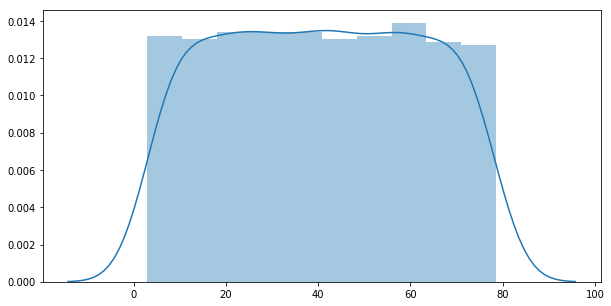

In [23]:
sns.distplot(amplitudes)

In [24]:
amplitudes_groups = pd.qcut(amplitudes, 20)
amplitudes_groups

[(2.9130000000000003, 7.368], (10.57, 14.433], (10.57, 14.433], (14.433, 18.238], (18.238, 22.12], ..., (59.004, 62.321], (62.321, 66.926], (66.926, 70.24], (70.24, 74.648], (74.648, 78.602]]
Length: 780
Categories (20, interval[float64]): [(2.9130000000000003, 7.368] < (7.368, 10.57] < (10.57, 14.433] < (14.433, 18.238] ... (62.321, 66.926] < (66.926, 70.24] < (70.24, 74.648] < (74.648, 78.602]]

In [25]:
mid_point = int((x_clean.shape[1]-1)/2)
R = CONFIG.spike_size
R = 10
MID_POINT_IDX = slice(mid_point - R, mid_point + R + 1)

In [26]:
from yass.augment import util

def to_data_frame(array):
    wfs = [a for a in array]
    df = pd.DataFrame(data={'waveforms': wfs,
                            'amplitudes': util.amplitudes(wfs)})
    return df

In [27]:
df = to_data_frame(x_noisy)

In [38]:
idx = df[(3 < df.amplitudes) & (df.amplitudes < 4)].index

In [15]:
def process_group(g_id, g, model):
    wfs = np.stack(g.waveforms.values, axis=0)
    preds = model.predict(wfs[:, MID_POINT_IDX, :])
    return g_id, preds.mean()

def compute_proportions(x_clean, ptp, model):
    # convert to data frame
    wfs = [x for x in x_clean]

    df = pd.DataFrame(data={"waveforms": wfs,
                            "ptp": ptp.repeat(n_per_cluster)})
    
    df.sort_values(by='ptp', inplace=True)
    
    # group and compute proportion of correct predictions
    vals = [process_group(g_id, g, model) for g_id, g in df.groupby('ptp')]
    
    ptps, props = list(zip(*vals))
    
    return ptps, props

In [16]:
paths = ['/home/Edu/shengao-models/detect_nn_min3max15_noise2.ckpt',
         '/home/Edu/dev/private-yass/nnet/models/detect-11-Jul-2018@21-00-57.ckpt']

In [17]:
plt.rcParams['figure.figsize'] = (10, 5)

colors = ['g', 'r', 'b', 'k']

for i, path_to_model in enumerate(paths):
    model = NeuralNetDetector.load(path_to_model, 0.5, CONFIG.channel_index)
    ptps, props = compute_proportions(x_clean, ptp, model)
    plt.scatter(ptps, props, color=colors[i],
                label=path_to_model.split('/')[-1])

plt.legend()

ValueError: arrays must all be same length